# Mixture Density Networks (MDN) Tutorial

## Overview
This notebook demonstrates the evolution from basic neural network regression to Mixture Density Networks (MDNs; Bishop 1994), showing why and how MDNs solve the limitations of standard regression approaches for complex conditional distributions.

### Learning Objectives
- Understand the limitations of standard neural networks for inverse/multi-modal problems
- Learn about heteroscedastic regression and likelihood-based training
- Implement and understand Mixture Density Networks
- See how MDNs handle non-bijective mappings and multi-modal distributions

### Key Concepts Covered
1. **Standard Neural Network Regression**: Basic MLP for forward and inverse problems
2. **Likelihood-based Training**: Using negative log-likelihood instead of MSE
3. **Heteroscedastic Regression**: Predicting both mean and variance
4. **Mixture Density Networks**: Modeling multi-modal conditional distributions
5. **Sampling from MDNs**: Generating samples from learned distributions

---

Richard Gao + Copilot, 2025

In [1]:
# =============================================================================
# IMPORTS AND SETUP
# =============================================================================

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('matplotlibrc_notebook')

# Core libraries
import numpy as np
import torch
from torch import nn, optim

# Progress bars for training loops
from tqdm import tqdm

# Fix for potential library conflicts on macOS
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print(f"Setup complete | PyTorch {torch.__version__} | Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Setup complete | PyTorch 2.5.1 | Device: CPU


In [2]:
# =============================================================================
# DATA GENERATION FUNCTIONS
# =============================================================================

def generate_data(n_samples, return_tensor=True, return_sorted=False, return_inverted=False):
    """
    Generate synthetic heteroscedastic data: y = 7*sin(0.75*x) + x + ε
    where ε ~ N(0, σ²) and σ = 1.5*(sin(x) + 1.5)
    """
    x_data = np.random.uniform(-10.5, 10.5, n_samples)
    
    # Generate heteroscedastic noise (variance depends on x)
    noise_scale = 1.5 * (np.sin(x_data) + 1.5)
    epsilon = np.random.normal(size=len(x_data), scale=noise_scale)
    
    # Generate y values with non-linear relationship
    y_data = 7 * np.sin(0.75 * x_data) + 1 * x_data + epsilon
    
    # Sometimes invert x and y for inverse problems
    if return_inverted:
        x_data, y_data = y_data, x_data
        
    if return_sorted:
        idx_sorted = np.argsort(x_data)
        x_data, y_data = x_data[idx_sorted], y_data[idx_sorted]
    
    if return_tensor:
        return (torch.from_numpy(x_data)[:, None].float(), 
                torch.from_numpy(y_data)[:, None].float())
    else:         
        return x_data, y_data


def label_xy(inverted_xy=False):
    """Add appropriate axis labels for plots."""
    if inverted_xy:
        plt.xlabel('y')
        plt.ylabel('x')
    else:
        plt.xlabel('x')
        plt.ylabel('y')

In [3]:
# =============================================================================
# DEMONSTRATION: CONDITIONAL DENSITY ESTIMATION
# =============================================================================

# Generate synthetic dataset
n_samples = 2000
x_data, y_data = generate_data(n_samples, return_tensor=False)

print(f"Generated {n_samples} data points | x: [{x_data.min():.2f}, {x_data.max():.2f}] | y: [{y_data.min():.2f}, {y_data.max():.2f}]")

# Demonstrate conditional density: p(x | y ≈ yo)
yo, eps = -5, 0.5
distance_from_yo = (y_data - yo) ** 2
y_conditional = y_data[distance_from_yo < eps]
x_conditional = x_data[distance_from_yo < eps]

print(f"Conditioning on y ≈ {yo} ± {eps}: found {len(x_conditional)} points → demonstrates multi-modal nature")

Generated 2000 data points | x: [-10.49, 10.47] | y: [-23.74, 20.78]
Conditioning on y ≈ -5 ± 0.5: found 100 points → demonstrates multi-modal nature


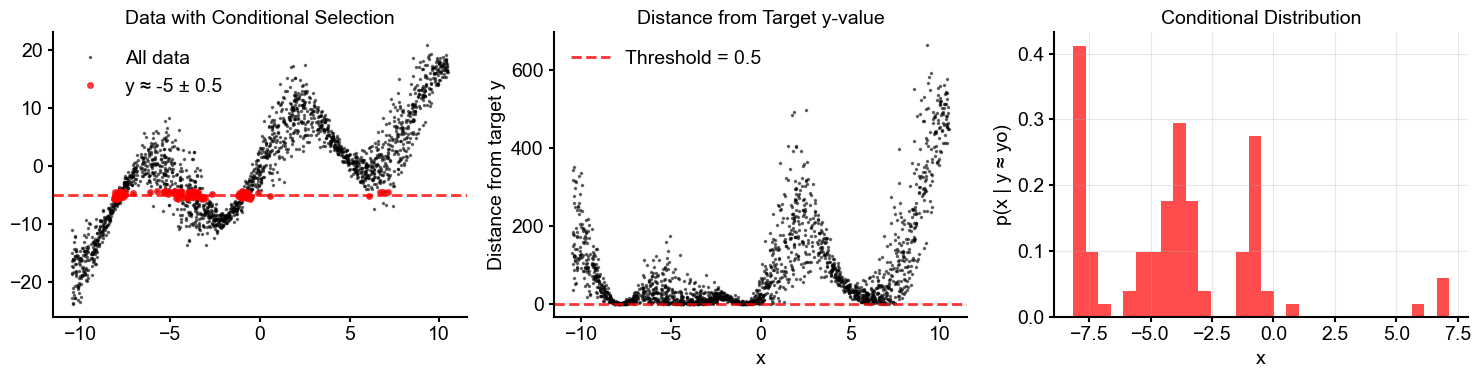

Key insight: For y ≈ -5, we see multiple probable x values
This multi-modal distribution is what standard regression struggles with!


In [4]:
# =============================================================================
# VISUALIZATION: CONDITIONAL DENSITY PROBLEM
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: Original data with conditional points highlighted
axes[0].plot(x_data, y_data, '.', alpha=0.5, color='k', label='All data')
axes[0].plot(x_conditional, y_conditional, 'o', color='red', alpha=0.7, 
             markersize=4, label=f'y ≈ {yo} ± {eps}')
axes[0].axhline(yo, color='red', linewidth=2, linestyle='--', alpha=0.8)
axes[0].set_title('Data with Conditional Selection')
axes[0].legend()
label_xy()

# Panel 2: Distance from target y value
axes[1].plot(x_data, distance_from_yo, '.', alpha=0.5, color='k')
axes[1].axhline(eps, color='red', linewidth=2, linestyle='--', alpha=0.8, 
                label=f'Threshold = {eps}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Distance from target y')
axes[1].set_title('Distance from Target y-value')
axes[1].legend()

# Panel 3: Posterior distribution p(x | y ≈ yo)
axes[2].hist(x_conditional, bins=30, alpha=0.7, color='red', density=True)
axes[2].set_xlabel('x')
axes[2].set_ylabel('p(x | y ≈ yo)')
axes[2].set_title('Conditional Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Key insight: For y ≈ {yo}, we see multiple probable x values")
print("This multi-modal distribution is what standard regression struggles with!")

---

## Part 1: Standard Neural Network Regression

**Objective**: Test standard MLP regression on heteroscedastic, non-linear data.

**Question**: Can a simple MLP handle our complex data distribution?

In [5]:
# =============================================================================
# NEURAL NETWORK ARCHITECTURE AND TRAINING
# =============================================================================

class MLP(nn.Module):
    """Multi-Layer Perceptron with 2 hidden layers and ReLU activations."""
    def __init__(self, n_in, n_h1, n_h2, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_h1), 
            nn.ReLU(),
            nn.Linear(n_h1, n_h2), 
            nn.ReLU(),
            nn.Linear(n_h2, n_out)
        )
    
    def forward(self, x):
        return self.net(x)


def train_loop(model, loss_fn, optimizer, n_epochs=1000, n_batch=1000, invert_xy=False, 
               desc="Training", verbose=True):
    """Training loop with progress bars."""
    losses = []
    pbar = tqdm(range(n_epochs), desc=desc) if verbose else range(n_epochs)
    
    for epoch in pbar:
        optimizer.zero_grad()
        x_train, y_train = generate_data(n_batch, return_inverted=invert_xy)
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
        current_loss = loss.detach().cpu().numpy()
        losses.append(current_loss)
        
        if verbose and hasattr(pbar, 'set_postfix') and epoch % max(1, n_epochs // 20) == 0:
            improvement = ((losses[0] - current_loss) / losses[0]) * 100
            pbar.set_postfix({'Loss': f'{current_loss:.4f}', 'Improve': f'{improvement:.1f}%'})
    
    if verbose:
        print(f"✓ {desc} complete: {losses[0]:.4f} → {losses[-1]:.4f} ({((losses[0] - losses[-1]) / losses[0] * 100):.1f}% improvement)")
    
    return np.array(losses)

In [6]:
# =============================================================================
# TRAINING: STANDARD MLP REGRESSION
# =============================================================================

# Training parameters
n_batch = 1000
n_epochs = 5000

# Initialize model, loss, and optimizer
mlp_reg = MLP(n_in=1, n_h1=64, n_h2=64, n_out=1)
loss_l2 = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(mlp_reg.parameters(), lr=1e-3)

print("\n🚀 Starting training...")
losses_mlp = train_loop(mlp_reg, loss_l2, optimizer, n_epochs, n_batch)


🚀 Starting training...


Training: 100%|██████████| 5000/5000 [00:05<00:00, 976.99it/s, Loss=6.0289, Improve=92.1%] 

✓ Training complete: 76.0303 → 6.8322 (91.0% improvement)


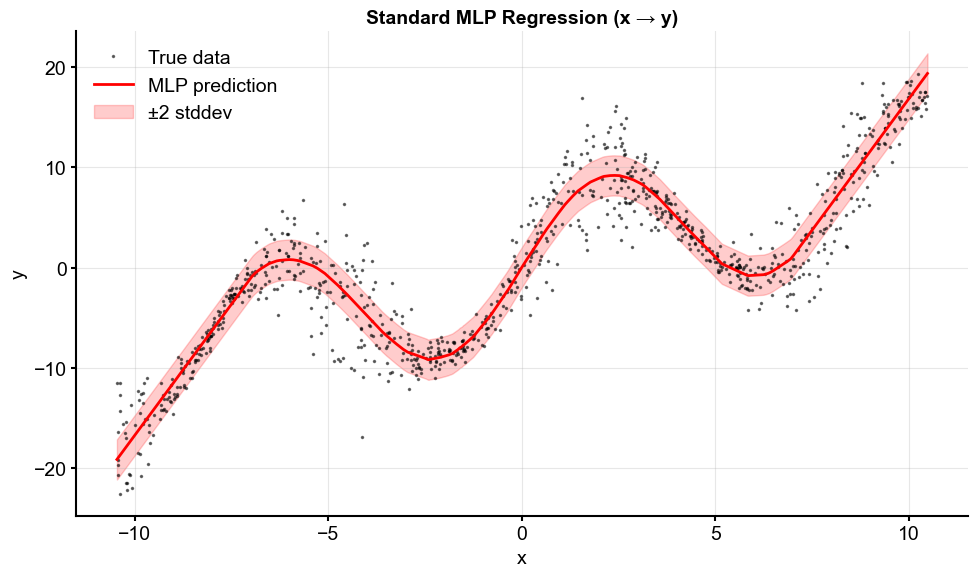

Model Performance: MSE=5.8579, MAE=1.7513
✅ Model captures the mean trend reasonably well!


In [7]:
# =============================================================================
# VISUALIZATION: STANDARD MLP REGRESSION RESULTS
# =============================================================================

# Generate test data
x_test, y_test = generate_data(1000, return_sorted=True)

plt.figure(figsize=(10, 6))

# Plot data points
plt.plot(x_test, y_test, '.', alpha=0.5, color='k', 
         markersize=3, label='True data')

# Plot model predictions
with torch.no_grad():
    y_pred = mlp_reg(x_test)
    plt.plot(x_test, y_pred, '-', color='red', linewidth=2, 
             label='MLP prediction')
    # plot model uncertainty, which is unity
    y_std = torch.ones_like(y_pred)
    plt.fill_between(x_test.squeeze().numpy(),
                        (y_pred - 2 * y_std).squeeze().numpy(),
                        (y_pred + 2 * y_std).squeeze().numpy(),
                        color='red', alpha=0.2, label='±2 stddev')

label_xy()
plt.title('Standard MLP Regression (x → y)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate some metrics
with torch.no_grad():
    y_pred = mlp_reg(x_test)
    mse = nn.functional.mse_loss(y_pred, y_test)
    mae = torch.mean(torch.abs(y_pred - y_test))

print(f"Model Performance: MSE={mse.item():.4f}, MAE={mae.item():.4f}")
print("✅ Model captures the mean trend reasonably well!")

**Key Observation**: This is homoscedastic regression - constant noise assumption, but our data has heteroscedastic noise (variance changes with x). The model only predicts the mean and cannot capture uncertainty.

---

**The Inverse Problem Challenge**

Testing **inverse mapping**: predicting x from y.

**Why challenging**: y → x is not a function (one y maps to multiple x). Creates multi-modal p(x|y). Standard networks can only predict single values.

**Expected result**: Model will predict "average" x and miss multi-modal nature.

In [8]:
# =============================================================================
# TRAINING: INVERSE MLP REGRESSION (y → x)
# =============================================================================

print("🔄 Training MLP for inverse regression (y → x)...")

optimizer = optim.Adam(mlp_reg.parameters(), lr=1e-3)
losses_mlp_inv = train_loop(mlp_reg, loss_l2, optimizer, 5000, 1000, 
                           invert_xy=True, verbose=True)

🔄 Training MLP for inverse regression (y → x)...


Training: 100%|██████████| 5000/5000 [00:05<00:00, 965.42it/s, Loss=15.4279, Improve=94.8%] 

✓ Training complete: 297.9065 → 15.5459 (94.8% improvement)


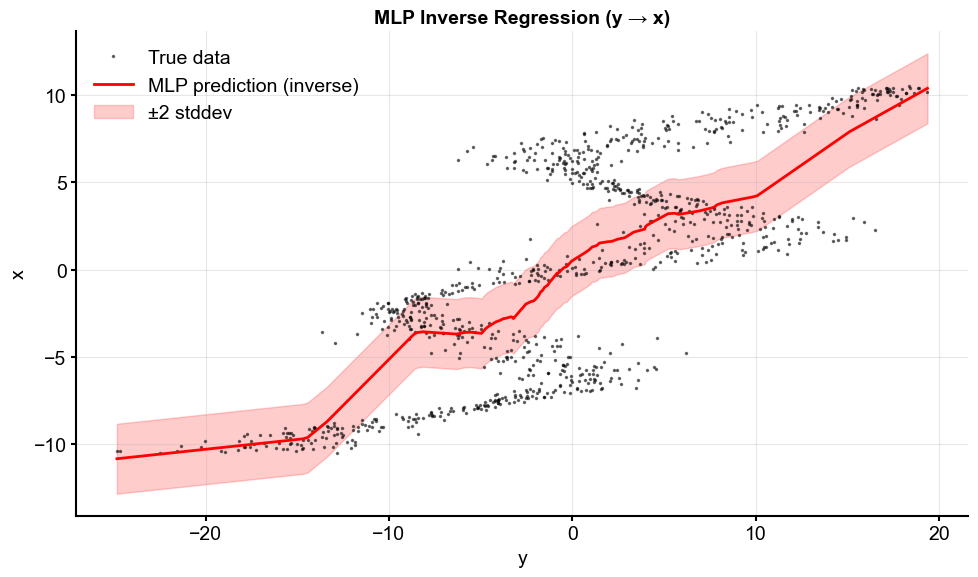

❌ Failure: Model predicts single x per y, misses multi-modal nature, only captures 'average' relationship!


In [9]:
# =============================================================================
# VISUALIZATION: INVERSE MLP REGRESSION RESULTS
# =============================================================================

# Generate test data (inverted: y as input, x as output)
x_test, y_test = generate_data(1000, return_sorted=True, return_inverted=True)

plt.figure(figsize=(10, 6))

# Plot true data
plt.plot(x_test, y_test, '.', alpha=0.5, color='k', 
         markersize=3, label='True data')

# Plot model predictions
with torch.no_grad():
    y_pred = mlp_reg(x_test)
    plt.plot(x_test, y_pred, '-', color='red', linewidth=2, 
             label='MLP prediction (inverse)')
    # plot model uncertainty, which is unity
    y_std = torch.ones_like(y_pred)
    plt.fill_between(x_test.squeeze().numpy(),
                        (y_pred - 2 * y_std).squeeze().numpy(),
                        (y_pred + 2 * y_std).squeeze().numpy(),
                        color='red', alpha=0.2, label='±2 stddev')

label_xy(inverted_xy=True)
plt.title('MLP Inverse Regression (y → x)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("❌ Failure: Model predicts single x per y, misses multi-modal nature, only captures 'average' relationship!")

**Key Insight**: Standard regression fails with non-bijective mappings, multi-modal distributions, and inverse relationships. Only predicts single values, essentially averaging over multiple outputs.

---

## Part 2: Likelihood-Based Training

**New Approach**: Use negative log-likelihood instead of MSE for probabilistic modeling, uncertainty quantification, and heteroscedastic noise handling.

In [10]:
# =============================================================================
# LIKELIHOOD-BASED LOSS FUNCTIONS
# =============================================================================

def negLL(y_true, y_pred_mean, y_pred_std):
    """
    Negative Log-Likelihood for Gaussian distributions.
    LL = -0.5 * log(2π * σ²) - (y - μ)² / (2σ²)
    """
    log_likelihood = (-0.5 * torch.log(2 * np.pi * y_pred_std**2) 
                     - (y_true - y_pred_mean)**2 / (2 * y_pred_std**2))
    return -log_likelihood.mean()

In [11]:
# =============================================================================
# TRAINING: HOMOSCEDASTIC NLL REGRESSION
# =============================================================================

print("Training MLP with negative log-likelihood (homoscedastic, σ=1)...")

mlp_ll = MLP(1, 64, 64, 1)
optimizer_nll = optim.Adam(mlp_ll.parameters(), lr=1e-3)

def homoscedastic_nll_loss(y_pred, y_true):
    return negLL(y_true, y_pred, torch.ones_like(y_true))

losses_nll = train_loop(mlp_ll, homoscedastic_nll_loss, optimizer_nll, 
                       5000, 1000, desc="Homoscedastic NLL")

Training MLP with negative log-likelihood (homoscedastic, σ=1)...


Homoscedastic NLL: 100%|██████████| 5000/5000 [00:05<00:00, 907.62it/s, Loss=4.2541, Improve=88.0%]

✓ Homoscedastic NLL complete: 35.5397 → 4.1781 (88.2% improvement)


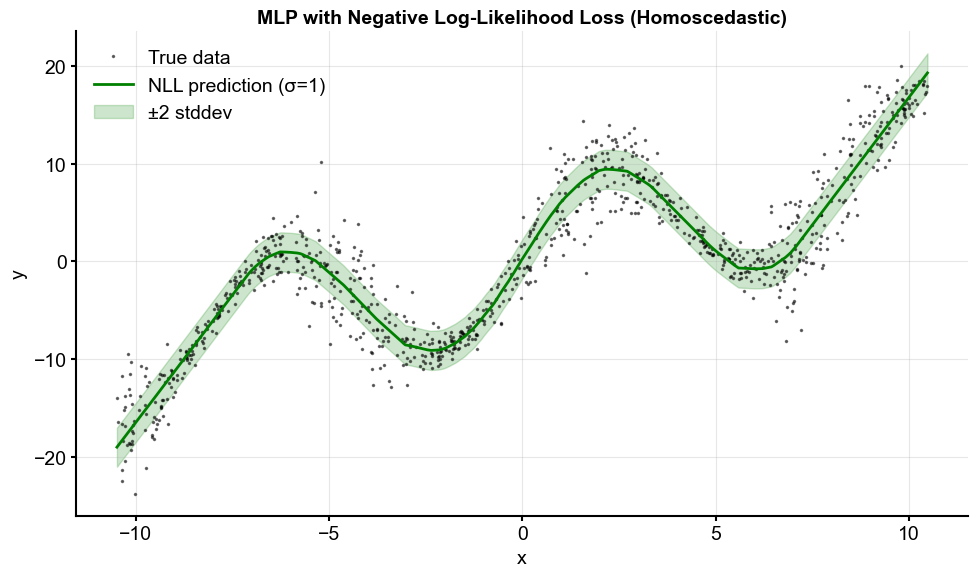

✅ NLL performs similarly to MSE but provides probabilistic foundation


In [12]:
# =============================================================================
# VISUALIZATION: HOMOSCEDASTIC NLL RESULTS
# =============================================================================

# Generate test data
x_test, y_test = generate_data(1000, return_sorted=True)

plt.figure(figsize=(10, 6))

# Plot data points
plt.plot(x_test, y_test, '.', alpha=0.5, color='k', 
         markersize=3, label='True data')

# Plot model predictions
with torch.no_grad():
    y_pred = mlp_ll(x_test)
    plt.plot(x_test, y_pred, '-', color='green', linewidth=2, 
             label='NLL prediction (σ=1)')
    # plot model uncertainty, which is unity
    y_std = torch.ones_like(y_pred)
    plt.fill_between(x_test.squeeze().numpy(),
                        (y_pred - 2 * y_std).squeeze().numpy(),
                        (y_pred + 2 * y_std).squeeze().numpy(),
                        color='green', alpha=0.2, label='±2 stddev')

label_xy()
plt.title('MLP with Negative Log-Likelihood Loss (Homoscedastic)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ NLL performs similarly to MSE but provides probabilistic foundation")

**Next: Heteroscedastic Regression**

Network predicts both μ(x) and log(σ(x)). Output layer has 2 neurons. Benefits: better uncertainty quantification, lower likelihood, foundation for mixture models.

In [13]:
# =============================================================================
# TRAINING: HETEROSCEDASTIC NLL REGRESSION
# =============================================================================

print("Training MLP with heteroscedastic NLL (predicts μ(x) and σ(x))...")

# Initialize model with 2 outputs: mean and log(std)
mlp_ll_hetero = MLP(1, 64, 64, 2)
optimizer_hetero = optim.Adam(mlp_ll_hetero.parameters(), lr=1e-3)

class HeteroscedasticTrainer:
    def __init__(self, model, optimizer):
        self.model, self.optimizer = model, optimizer
    
    def train_epoch(self, n_batch):
        self.optimizer.zero_grad()
        x_train, y_train = generate_data(n_batch)
        
        # Forward pass: predict both mean and log(std)
        y_musigma = self.model(x_train)
        mus = y_musigma[:, 0].view(-1, 1)
        sigmas = torch.exp(y_musigma[:, 1]).view(-1, 1)
        loss = negLL(y_train, mus, sigmas)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().numpy()

trainer = HeteroscedasticTrainer(mlp_ll_hetero, optimizer_hetero)
losses_hetero = []

pbar = tqdm(range(5000), desc="Heteroscedastic NLL")
for epoch in pbar:
    loss = trainer.train_epoch(1000)
    losses_hetero.append(loss)
    if epoch % 250 == 0:
        improvement = ((losses_hetero[0] - loss) / losses_hetero[0]) * 100
        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Improve': f'{improvement:.1f}%'})

losses_hetero = np.array(losses_hetero)
print(f"✓ Training complete: {losses_hetero[0]:.4f} → {losses_hetero[-1]:.4f}")

Training MLP with heteroscedastic NLL (predicts μ(x) and σ(x))...


Heteroscedastic NLL: 100%|██████████| 5000/5000 [00:06<00:00, 827.97it/s, Loss=2.0931, Improve=97.2%]

✓ Training complete: 74.9156 → 2.0936


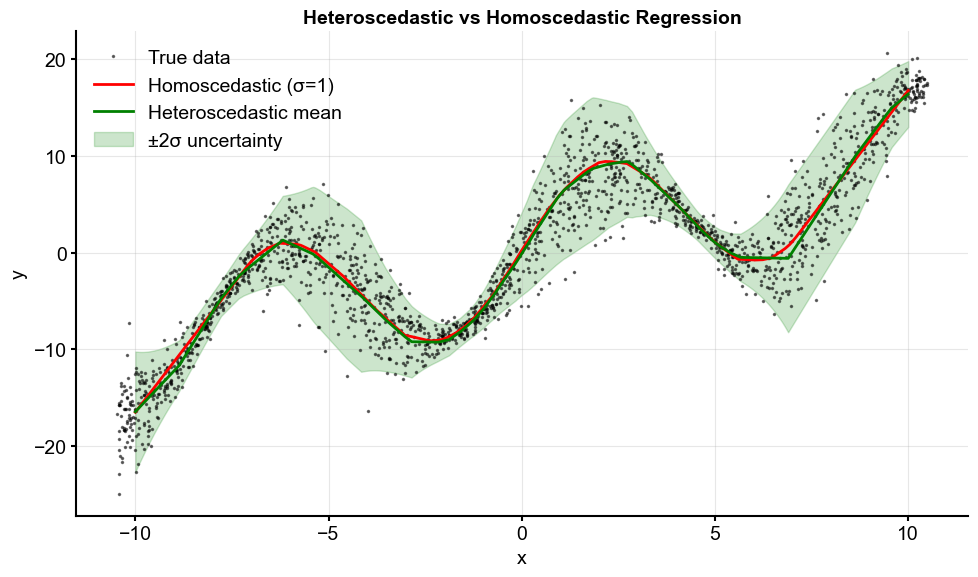

✅ Heteroscedastic model captures varying uncertainty and reflects true noise structure


In [14]:
# =============================================================================
# VISUALIZATION: HETEROSCEDASTIC REGRESSION RESULTS
# =============================================================================

x_test, y_test = generate_data(2000, return_sorted=True)
plt.figure(figsize=(10, 6))

# Plot data points
plt.plot(x_test, y_test, '.', alpha=0.5, color='k', markersize=3, label='True data')

# Create high-resolution test input for smooth curves
x_test_smooth = torch.arange(-10, 10, 0.001)[:, None].float()

with torch.no_grad():
    # Homoscedastic prediction
    plt.plot(x_test_smooth, mlp_ll(x_test_smooth), '-', color='red', linewidth=2, 
             label='Homoscedastic (σ=1)')
    
    # Heteroscedastic predictions
    y_musigma = mlp_ll_hetero(x_test_smooth)
    mus, sigmas = y_musigma[:, 0].view(-1, 1), torch.exp(y_musigma[:, 1]).view(-1, 1)    
    plt.plot(x_test_smooth, mus, '-', color='green', linewidth=2, 
             label='Heteroscedastic mean')
    plt.fill_between(x_test_smooth.squeeze(), 
                     (mus - sigmas * 2).squeeze(), 
                     (mus + sigmas * 2).squeeze(), 
                     color='green', alpha=0.2, label='±2σ uncertainty')

label_xy()
plt.title('Heteroscedastic vs Homoscedastic Regression', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Heteroscedastic model captures varying uncertainty and reflects true noise structure")

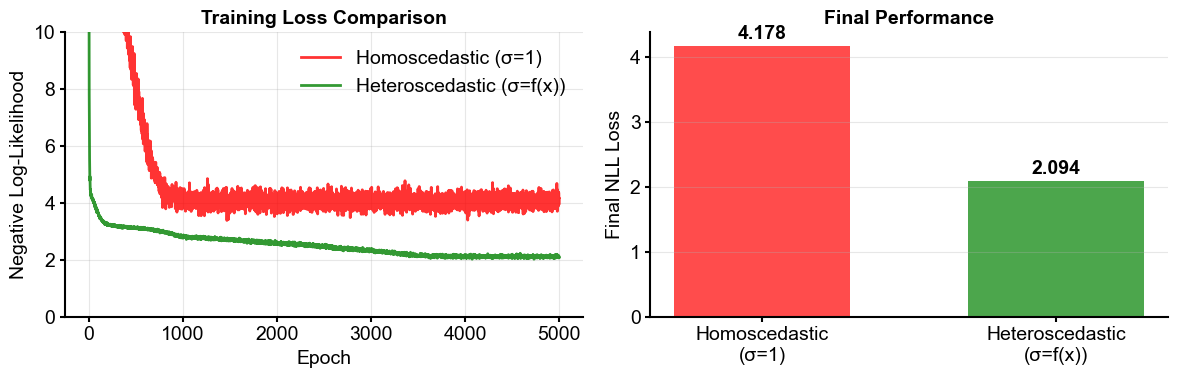

Performance: Homoscedastic 4.1781 vs Heteroscedastic 2.0936
✅ 49.9% better likelihood with heteroscedastic modeling


In [15]:
# =============================================================================
# COMPARISON: HOMOSCEDASTIC vs HETEROSCEDASTIC TRAINING
# =============================================================================

plt.figure(figsize=(12, 4))

# Plot 1: Loss curves comparison
plt.subplot(1, 2, 1)
with torch.no_grad():
    plt.plot(losses_nll, 'red', linewidth=2, label='Homoscedastic (σ=1)', alpha=0.8)
    plt.plot(losses_hetero, 'green', linewidth=2, label='Heteroscedastic (σ=f(x))', alpha=0.8)

plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss Comparison', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0, 10])

# Plot 2: Final loss values
plt.subplot(1, 2, 2)
final_losses = [losses_nll[-1], losses_hetero[-1]]
labels = ['Homoscedastic\n(σ=1)', 'Heteroscedastic\n(σ=f(x))']
colors = ['red', 'green']

bars = plt.bar(labels, final_losses, color=colors, alpha=0.7, width=0.6)
plt.ylabel('Final NLL Loss')
plt.title('Final Performance', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, loss in zip(bars, final_losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{loss:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

improvement = ((losses_nll[-1] - losses_hetero[-1]) / losses_nll[-1]) * 100
print(f"Performance: Homoscedastic {losses_nll[-1]:.4f} vs Heteroscedastic {losses_hetero[-1]:.4f}")
print(f"✅ {improvement:.1f}% better likelihood with heteroscedastic modeling")

**Testing inverse heteroscedastic regression (y → x)**

In [16]:
# =============================================================================
# TRAINING: INVERSE HETEROSCEDASTIC REGRESSION (y → x)
# =============================================================================

print("🔄 Training inverse heteroscedastic regression (y → x)...")

mlp_ll_hetero_inv = MLP(1, 64, 64, 2)
optimizer_inv = optim.Adam(mlp_ll_hetero_inv.parameters(), lr=1e-3)

class InverseHeteroscedasticTrainer:
    def __init__(self, model, optimizer):
        self.model, self.optimizer = model, optimizer
    
    def train_epoch(self, n_batch):
        self.optimizer.zero_grad()
        x_train, y_train = generate_data(n_batch, return_inverted=True)
        y_musigma = self.model(x_train)
        mus = y_musigma[:, 0].view(-1, 1)
        sigmas = torch.exp(y_musigma[:, 1]).view(-1, 1)
        loss = negLL(y_train, mus, sigmas)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().numpy()

trainer_inv = InverseHeteroscedasticTrainer(mlp_ll_hetero_inv, optimizer_inv)
losses_hetero_inv = []

pbar = tqdm(range(5000), desc="Inverse Heteroscedastic")
for epoch in pbar:
    loss = trainer_inv.train_epoch(1000)
    losses_hetero_inv.append(loss)
    if epoch % 250 == 0:
        improvement = ((losses_hetero_inv[0] - loss) / losses_hetero_inv[0]) * 100
        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Improve': f'{improvement:.1f}%'})

losses_hetero_inv = np.array(losses_hetero_inv)
print(f"✓ Better uncertainty modeling but still struggles with multi-modal nature")

🔄 Training inverse heteroscedastic regression (y → x)...


Inverse Heteroscedastic: 100%|██████████| 5000/5000 [00:06<00:00, 822.16it/s, Loss=2.6558, Improve=70.7%]

✓ Better uncertainty modeling but still struggles with multi-modal nature


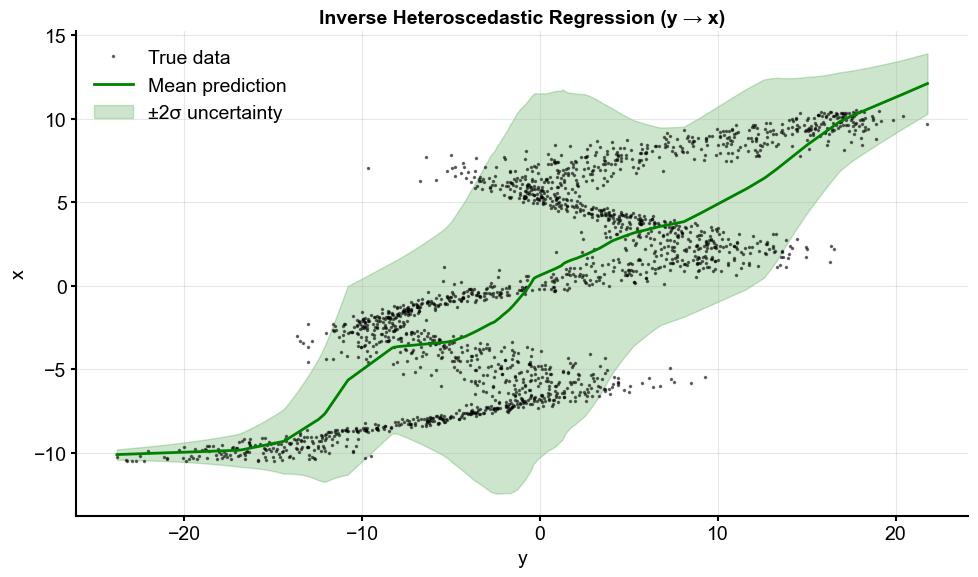

Analysis: Mean struggles with multi-modal nature, but uncertainty bands are wider in complex regions


In [17]:
# =============================================================================
# VISUALIZATION: INVERSE HETEROSCEDASTIC REGRESSION RESULTS
# =============================================================================

x_test, y_test = generate_data(2000, return_sorted=True, return_inverted=True)
plt.figure(figsize=(10, 6))

# Plot data points
plt.plot(x_test, y_test, '.', alpha=0.5, color='k', markersize=3, label='True data')

# Plot model predictions with uncertainty
with torch.no_grad():
    y_musigma = mlp_ll_hetero_inv(x_test)
    mus, sigmas = y_musigma[:, 0].view(-1, 1), torch.exp(y_musigma[:, 1]).view(-1, 1)    
    plt.plot(x_test, mus, '-', color='green', linewidth=2, label='Mean prediction')
    plt.fill_between(x_test.squeeze(), 
                     (mus - sigmas * 2).squeeze(), 
                     (mus + sigmas * 2).squeeze(), 
                     color='green', alpha=0.2, label='±2σ uncertainty')

label_xy(inverted_xy=True)
plt.title('Inverse Heteroscedastic Regression (y → x)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Analysis: Mean struggles with multi-modal nature, but uncertainty bands are wider in complex regions")

**As expected**: Mean prediction is poor but variance modeling is improved (thicker bands in middle section).

---

---

## Part 3: Mixture Density Networks (MDN)

**The Solution**: Model conditional distributions as mixtures of Gaussians:
$$p(x|y) = \sum_{k=1}^K \pi_k(y) \cdot \mathcal{N}(x; \mu_k(y), \sigma_k^2(y))$$

**How it works**: Network outputs 3K values per input for K components:
- 🎲 Mixing coefficients π_k(y) 
- 📍 Component means μ_k(y)
- 📏 Component variances σ_k(y)

**Benefits**: Handles multi-modal distributions, proper uncertainty, realistic sampling.

In [18]:
# =============================================================================
# MIXTURE DENSITY NETWORK IMPLEMENTATION
# =============================================================================

class MDN(nn.Module):
    """Mixture Density Network: predicts mixture of Gaussians for conditional density modeling."""
    def __init__(self, n_in, n_h1, n_h2, n_gaussians):
        super().__init__()
        self.n_gaussians = n_gaussians
        self.net = MLP(n_in, n_h1, n_h2, n_gaussians * 3)  # π, μ, σ for each component
        
    def forward(self, x):
        g_params = self.net(x)
        alphas = nn.functional.softmax(g_params[:, 0::3], dim=1)  # Σπ = 1
        mus = g_params[:, 1::3]                                   # No constraints
        sigmas = g_params[:, 2::3].exp()                          # σ > 0
        return alphas, mus, sigmas

# Gaussian PDF computation
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0 * np.pi)

def gaussian_distribution(y, mu, sigma):
    """Compute Gaussian PDF values."""
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(alphas, sigmas, mus, y_true):
    """Negative log-likelihood for mixture: -log(Σ_k π_k * N(y; μ_k, σ_k²))"""
    weighted_gaussians = gaussian_distribution(y_true, mus, sigmas) * alphas
    mixture_likelihood = torch.sum(weighted_gaussians, dim=1)
    return torch.mean(-torch.log(mixture_likelihood + 1e-8))


In [19]:
# =============================================================================
# TRAINING: MIXTURE DENSITY NETWORK
# =============================================================================

print("🎯 Training Mixture Density Network (5 components, 10k epochs)...")

mdn = MDN(n_in=1, n_h1=64, n_h2=64, n_gaussians=5)
optimizer_mdn = optim.Adam(mdn.parameters(), lr=1e-3)

class MDNTrainer:
    def __init__(self, model, optimizer):
        self.model, self.optimizer = model, optimizer
    
    def train_epoch(self, n_batch):
        self.optimizer.zero_grad()
        x_train, y_train = generate_data(n_batch, return_inverted=True)
        alphas, mus, sigmas = self.model(x_train)
        loss = mdn_loss_fn(alphas, sigmas, mus, y_train)
        loss.backward()
        self.optimizer.step()
        return loss.detach().cpu().numpy()

trainer_mdn = MDNTrainer(mdn, optimizer_mdn)
losses_mdn = []

pbar = tqdm(range(10000), desc="MDN Training")
for epoch in pbar:
    loss = trainer_mdn.train_epoch(1000)
    losses_mdn.append(loss)
    if epoch % 500 == 0:
        improvement = ((losses_mdn[0] - loss) / losses_mdn[0]) * 100
        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Improve': f'{improvement:.1f}%'})

losses_mdn = np.array(losses_mdn)
print(f"✓ MDN training complete: {losses_mdn[0]:.4f} → {losses_mdn[-1]:.4f}")

🎯 Training Mixture Density Network (5 components, 10k epochs)...


MDN Training: 100%|██████████| 10000/10000 [00:15<00:00, 626.58it/s, Loss=1.7440, Improve=78.8%]

✓ MDN training complete: 8.2321 → 1.7857


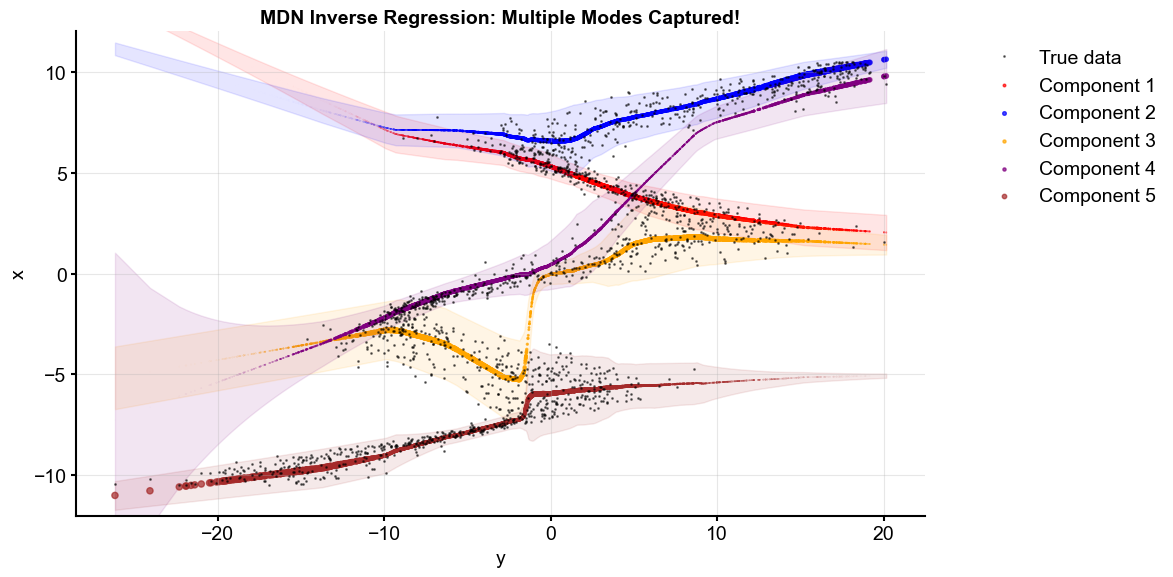

🎉 Success: Each component captures different modes, mixing weights show importance


In [20]:
# =============================================================================
# VISUALIZATION: MDN RESULTS
# =============================================================================

x_test, y_test = generate_data(2000, return_sorted=True, return_inverted=True)
plt.figure(figsize=(12, 6))

with torch.no_grad():
    alphas, mus, sigmas = mdn(x_test)
    
    # Plot true data points
    plt.plot(x_test, y_test, '.', alpha=0.5, color='k', markersize=2, label='True data')
    
    # Plot each mixture component
    colors = ['red', 'blue', 'orange', 'purple', 'brown']
    for i in range(5):
        plt.scatter(x_test, mus[:, i], s=alphas[:, i] * 20, color=colors[i], 
                   alpha=0.7, label=f'Component {i+1}')
        
        # Plot uncertainty bands for each component
        plt.fill_between(x_test.squeeze(), 
                        (mus[:, i] - sigmas[:, i] * 2).squeeze(), 
                        (mus[:, i] + sigmas[:, i] * 2).squeeze(), 
                        color=colors[i], alpha=0.1)

plt.ylim(-12, 12)
label_xy(inverted_xy=True)
plt.title('MDN Inverse Regression: Multiple Modes Captured!', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("🎉 Success: Each component captures different modes, mixing weights show importance")

**Now sampling from the MDN**

In [21]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

n_samples = 2000
k = gumbel_sample(alphas)
indices = (np.arange(n_samples), k.numpy())
rn = np.random.randn(n_samples)
sampled = torch.from_numpy(rn) * sigmas[indices] + mus[indices]

/var/folders/x7/7mxz7r0x2dn1n4_xxtp8xgx00000gn/T/ipykernel_64600/3313379284.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (np.log(x) + z).argmax(axis=axis)


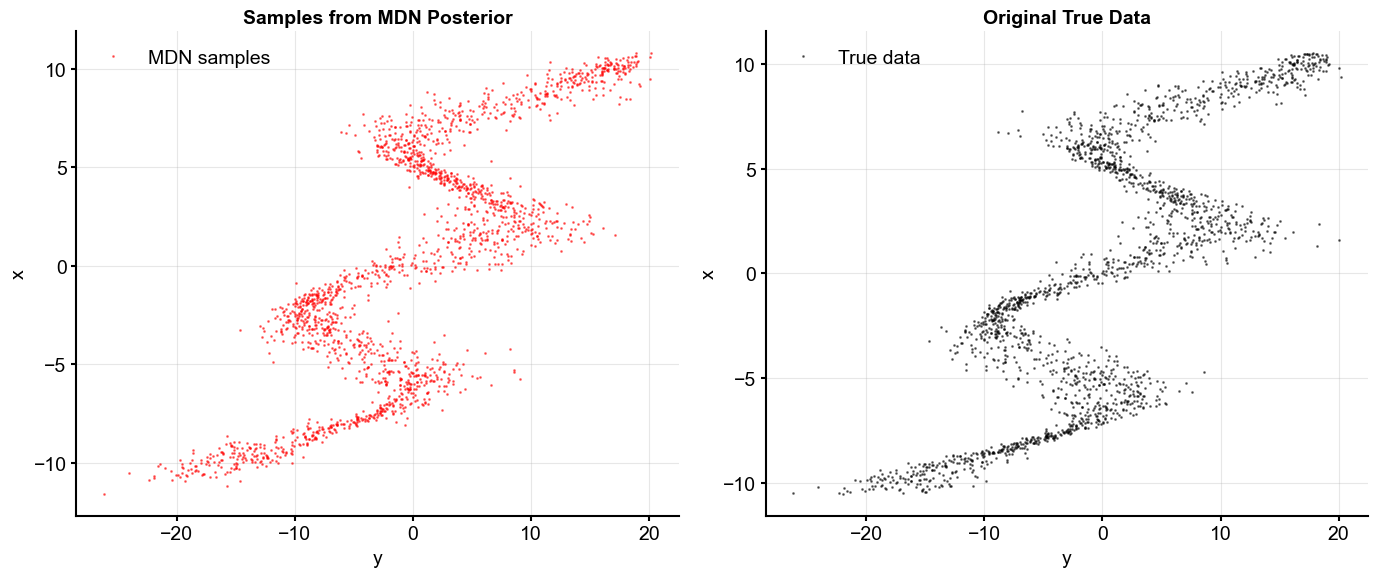

🎯 Sampling Assessment:
   • MDN samples closely match true data distribution
   • Multi-modal structure preserved in generated samples
   • Successful density modeling demonstrated!


In [22]:
# =============================================================================
# VISUALIZATION: MDN SAMPLING COMPARISON
# =============================================================================

plt.figure(figsize=(14, 6))

# Panel 1: Samples from MDN posterior
plt.subplot(1, 2, 1)
plt.plot(x_test, sampled, '.', alpha=0.5, color='red', markersize=2, label='MDN samples')
plt.title('Samples from MDN Posterior', fontsize=14, fontweight='bold')
label_xy(inverted_xy=True)
plt.legend()
plt.grid(True, alpha=0.3)

# Panel 2: True data for comparison
plt.subplot(1, 2, 2)
plt.plot(x_test, y_test, '.', alpha=0.5, color='k', markersize=2, label='True data')
plt.title('Original True Data', fontsize=14, fontweight='bold')
label_xy(inverted_xy=True)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 Sampling Assessment:")
print("   • MDN samples closely match true data distribution")
print("   • Multi-modal structure preserved in generated samples")
print("   • Successful density modeling demonstrated!")
